In [44]:
import numpy as np
from netCDF4 import Dataset
from scipy.stats import linregress
import os
import xarray as xr

import pymannkendall as mk

# base_dir = '/project/6006412/goldford/data_temp/extract_results/' 
pattern = 'SalishSea1500-RUN216_1d_grid_T_y{}m{:02d}.nc'
base_dir = 'D:/temp_nemo/' 


def mann_kendall_trend(data):
    # You may need to preprocess the data here if it's not in the right format
    # For example, convert it to a pandas Series if it's not already
    #data_series = pd.Series(data)
    
    # Apply the Mann-Kendall test
    result = mk.original_test(data)
    return result.slope, result.h

def trends_3D(variables):
    for variable in variables:
        for depth_group in depth_groups:
            for season in seasons:
                filename = f'weekly_anom_{variable}_{depth_group}_{season}_1980-2018.nc'
                anom_f = os.path.join(base_dir, 'anomalies/', filename)

                print("getting trend for " + variable + " in " + season)
                ds = xr.open_dataset(anom_f)  # Open the NetCDF file using xarray

                # Calculate yearly average for each cell
                yearly_avgs = ds[variable].groupby("time_counter.year").mean(dim="time_counter")       

                #                     #trend through each pixel-slice 
                #                     # https://stackoverflow.com/questions/66594056/linear-regression-on-each-grid-cell-across-time-dim
                #                     lin_fit = yearly_avgs.polyfit('year', deg=1, skipna=True)
                #                     # y = mx + b
                #                     a = lin_fit.sel(degree=1) # slopes of linregress
                #                     b = lin_fit.sel(degree=0)


                # Mann Kendall test 
                # pymannkendall
                # takes a vector list as input
                slopes, trend_tf = xr.apply_ufunc(
                    mann_kendall_trend,
                    yearly_avgs,
                    input_core_dims=[["year"]],
                    output_core_dims=[[],[]],
                    vectorize=True,
                    dask="allowed"#,
                    #output_dtypes=[float]
                )

                #                     ds_out = results_ds.to_dataset()()
                #                     ds_out["TF"] = trend_tf

                # Create a new dataset for writing
                trend_dataset = xr.Dataset(
                 {
                     "nav_lat": ds["nav_lat"],
                     "nav_lon": ds["nav_lon"],
                     "slope": (("y", "x"), slopes.values),
                     "sig_tf":(("y", "x"), trend_tf.values),
                 },
                 coords={"y": ds["y"], "x": ds["x"]},
                )

                # Set attributes for variables
                trend_dataset["nav_lat"].attrs = ds["nav_lat"].attrs
                trend_dataset["nav_lon"].attrs = ds["nav_lon"].attrs

                # Write the dataset to a new NetCDF file
                output_filename = f'trend_slopes_{variable}_{depth_group}_{season}.nc'
                output_path = os.path.join(base_dir, 'trend_output/', output_filename)
                trend_dataset.to_netcdf(output_path)

                ds.close()  # Close the dataset

def trends_2D(variables):
    for variable in variables:
        for season in seasons:
            filename = f'weekly_anom_{variable}_{season}_1980-2018.nc'
            anom_f = os.path.join(base_dir, 'anomalies/', filename)

            print("getting trend for " + variable + " in " + season)
            ds = xr.open_dataset(anom_f)  # Open the NetCDF file using xarray

            # Calculate yearly average for each cell
            yearly_avgs = ds[variable].groupby("time_counter.year").mean(dim="time_counter") 

            #trend through each pixel-slice 
            # https://stackoverflow.com/questions/66594056/linear-regression-on-each-grid-cell-across-time-dim
            lin_fit = yearly_avgs.polyfit('year', deg=1, skipna=True)
            # y = mx + b
            a = lin_fit.sel(degree=1) # slopes of linregress
            b = lin_fit.sel(degree=0)

            # Create a new dataset for writing
            trend_dataset = xr.Dataset(
                {
                    "nav_lat": ds["nav_lat"],
                    "nav_lon": ds["nav_lon"],
                    "slope": (("y", "x"), a['polyfit_coefficients'].values),
                },
                coords={"y": ds["y"], "x": ds["x"]},
            )

            # Set attributes for variables
            trend_dataset["nav_lat"].attrs = ds["nav_lat"].attrs
            trend_dataset["nav_lon"].attrs = ds["nav_lon"].attrs

            # Write the dataset to a new NetCDF file
            output_filename = f'trend_slopes_{variable}_{season}.nc'
            output_path = os.path.join(base_dir, 'trend_output/', output_filename)
            trend_dataset.to_netcdf(output_path)

            ds.close()  # Close the dataset
            


years = np.arange(1980, 2019, 1)
seasons = ['winter', 'spring', 'summer', 'fall']
depth_groups = ["0to30m", "30to150m", "gt150m", "allz"]

if __name__ == "__main__":
    variables = ['votemper', 'vosaline', 'vomecrty', 'vozocrtx']
    variables = ['votemper']
    seasons = ['winter']
    depth_groups = ["0to30m"]
    trends_3D(variables)
    #variables = ['mldkz5', 'mldr10_1']
    #trends_2D(variables)


getting trend for votemper in winter


In [52]:
np.arange(1980, 2019, 1)

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

result of lin_fit


C:\Users\Greig\AppData\Local\Temp\ipykernel_16256\2307652673.py:18: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, a['polyfit_coefficients'].values, cmap='viridis', shading='auto')


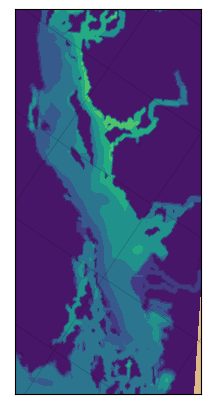

result of Mann Kendall
<xarray.DataArray 'votemper' (y: 299, x: 132)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    nav_lat  (y, x) float32 ...
    nav_lon  (y, x) float32 ...
Dimensions without coordinates: y, x


C:\Users\Greig\AppData\Local\Temp\ipykernel_16256\2307652673.py:34: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, result.values, cmap='viridis', shading='auto')


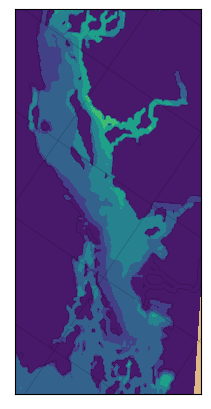

C:\Users\Greig\AppData\Local\Temp\ipykernel_16256\2307652673.py:50: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, trend_tf * result_ds, cmap='viridis', shading='auto')


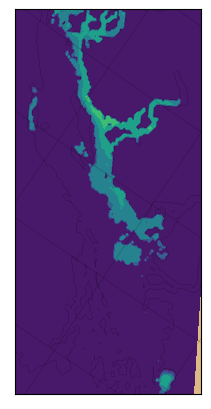

In [41]:
print("result of lin_fit")

grid_p = '../data/bathymetry/'
grid_f = 'bathy_salishsea_1500m_20210706.nc'
grid = xr.open_dataset(os.path.join(grid_p, grid_f), mask_and_scale=False)




fig, ax = plt.subplots(figsize=(5,5)) #w,h
# m returns projection
m = make_map(ax,
         grid,
         w_map=[-130, -115, 41, 60],
         rotation=43,
         par_inc=0.5,
         mer_inc=1
        )
adjust_map(ax,m)
x, y = m(grid['nav_lon'], grid['nav_lat'])
c = m.contourf(x, y, a['polyfit_coefficients'].values, cmap='viridis', shading='auto')
plt.show()




C:\Users\Greig\AppData\Local\Temp\ipykernel_16256\193204769.py:16: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, trend['slope'] * trend['sig_tf'], cmap='viridis', shading='auto')


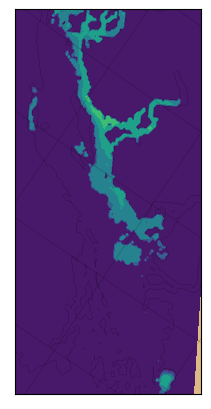

In [50]:
trend_p = 'D:/temp_nemo/trend_output/'
trend_f = 'trend_slopes_votemper_0to30m_winter.nc'
trend = xr.open_dataset(os.path.join(trend_p, trend_f), mask_and_scale=False)

fig, ax = plt.subplots(figsize=(5,5)) #w,h
# m returns projection
m = make_map(ax,
         grid,
         w_map=[-130, -115, 41, 60],
         rotation=43,
         par_inc=0.5,
         mer_inc=1
        )
adjust_map(ax,m)
x, y = m(grid['nav_lon'], grid['nav_lat'])
c = m.contourf(x, y, trend['slope'] * trend['sig_tf'], cmap='viridis', shading='auto')
plt.show()

In [51]:
tmask


NameError: name 'tmask' is not defined

In [7]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib import patches

import netCDF4 as nc



def make_map(ax, grid, w_map=[-124, -123.9, 47.7, 50.6], rotation=39.2, par_inc=0.25, mer_inc=0.5, fs=7):
    """
    """

    # Make projection
    m = Basemap(ax=ax, 
                projection='lcc', resolution='c',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0] + rotation,
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])
    
    # Add features and labels
    x, y = m(grid.nav_lon.values, grid.nav_lat.values)
    ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black', linewidths=0.1)
#     m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=fs)
    m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
#     m.drawparallels(np.arange(48, 51, par_inc), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=fs)
    m.drawparallels(np.arange(48, 51, par_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
    
    return m

def adjust_map(ax,m):
    
    # set desired width using map units
    # bottom left
    lat_bl, lon_bl = 47.8, -123.2 
    x_bl,y_bl = m(lon_bl,lat_bl)
    # bottom right
    lat_br, lon_br = 48.8, -122.28 
    x_br,_ = m(lon_br,lat_br)
    ax.set_xlim(x_bl, x_br)

    # top left
    lat_tl, lon_tl = 50.3, -124.75
    x_tl, y_tl = m(lon_tl, lat_tl)

    lat_bl, lon_bl = 48.2, -123.5
    x_bl,y_bl = m(lon_bl,lat_bl)
    ax.set_ylim(y_bl, y_tl)

    # fix a little path in bottom right
    lccx_TL, lccy_TL = m(-122.83, 49.4)
    lccx_BR, lccy_BR = m(-122.58, 48.7)
    lccx_BL, lccy_BL = m(-122.33, 48.7)
    lccw = lccx_BL - lccx_BR
    lcch = lccy_TL - lccy_BL

    ax.add_patch(patches.Rectangle(
                (lccx_BL, lccy_BL), lccw, lcch, 
                facecolor='burlywood', edgecolor='k',
                linewidth=0,
                zorder=0))

